[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


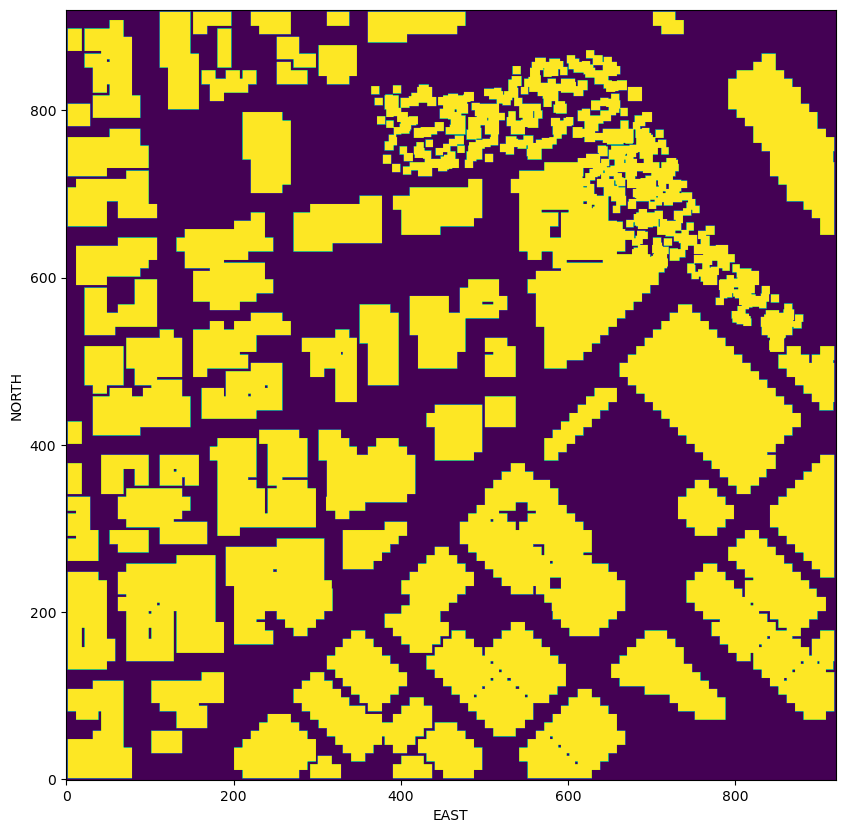

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

# Load a map of San Fransico, California.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', skiprows=2)
"""
The first row in Colliders.csv is the lat, lon of the map's center.
The second row is "posX,posY,posZ,halfSizeX,halfSizeY,halfSizeZ"
The rows following that contain the corresponding information, measured in meters.

x -> North
y -> East
z -> Up
"""
print(data)
# Consider a 5 meter drone altitude. 
drone_altitude = 5
# Also, consider a 3 meter safe distance padding each obstacle.
safe_distance = 3

def create_grid(data, drone_altitude, safety_distance):
    """
    Inputs: data, 2d numpy array of obstacles and free space; 
        drone_altitude: drone altitude in meters above the ground;
        safety_distance: desired safety distance, in meters, around
            obstacles. 
    Returns: 2d configuration space
    """
    # First, calculate the minimum and maximum north coordinates.
    north_min = np.floor(np.amin(data[:,0] - data[:,3]))
    north_max = np.ceil(np.amax(data[:,0] + data[:,3]))

    # Second, calculate the minimum and maximum east coordinates.
    east_min = np.floor(np.amin(data[:,1] - data[:,4]))
    east_max = np.ceil(np.amax(data[:,1] + data[:,4]))

    # Third, calculate the grid's size.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))

    # Fourth, initialize an empty grid. 
    grid = np.zeros((north_size, east_size))
    
    # Fifth, establish grid offsetes. 
    north_min_center = np.min(data[:,0])
    east_min_center = np.min(data[:,1])
    
    # Sixth, populate the grid with obstacles. 
    # Consider each obstacle in data. Build a rectangle of 1-m's around it. 
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i,:]
        
        if (drone_altitude < alt + d_alt and drone_altitude > alt - d_alt):
            north_rel = north - north_min_center # How many meters north the obstacle is from home.
            east_rel = east - east_min_center # How many meters east the obstacle is from home. 

            north_index_min = int(north_rel - d_north - safety_distance)
            north_index_max = int(north_rel + d_north + safety_distance)
            east_index_min = int(east_rel - d_east - safety_distance)
            east_index_max = int(east_rel + d_east + safety_distance)

            # Only make it an obstacle if it's an obstacle at the given height.
            grid[north_index_min:north_index_max+1, east_index_min:east_index_max+1] = 1
        
        
    
    return grid

grid = create_grid(data, drone_altitude, safe_distance)
print(grid)
DF = pd.DataFrame(grid)
DF.to_csv("grid_output.csv")

plt.imshow(grid, origin='lower') 
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [42]:
import numpy as np

M = np.array([[4, 1, 1, 5],
          [0, 5, -3, 7],
          [-5, -2, -1, 9],
             [4, 2, 1, 1]])
print(M)
print(M[0:2,1:3])


[[ 4  1  1  5]
 [ 0  5 -3  7]
 [-5 -2 -1  9]
 [ 4  2  1  1]]
[[ 1  1]
 [ 5 -3]]
